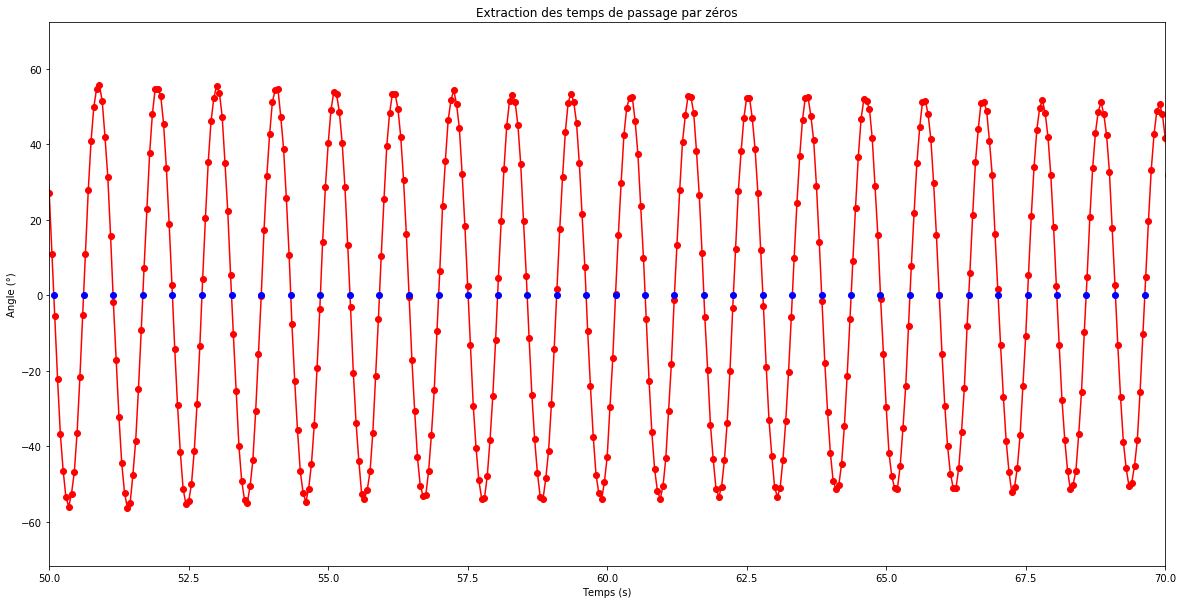

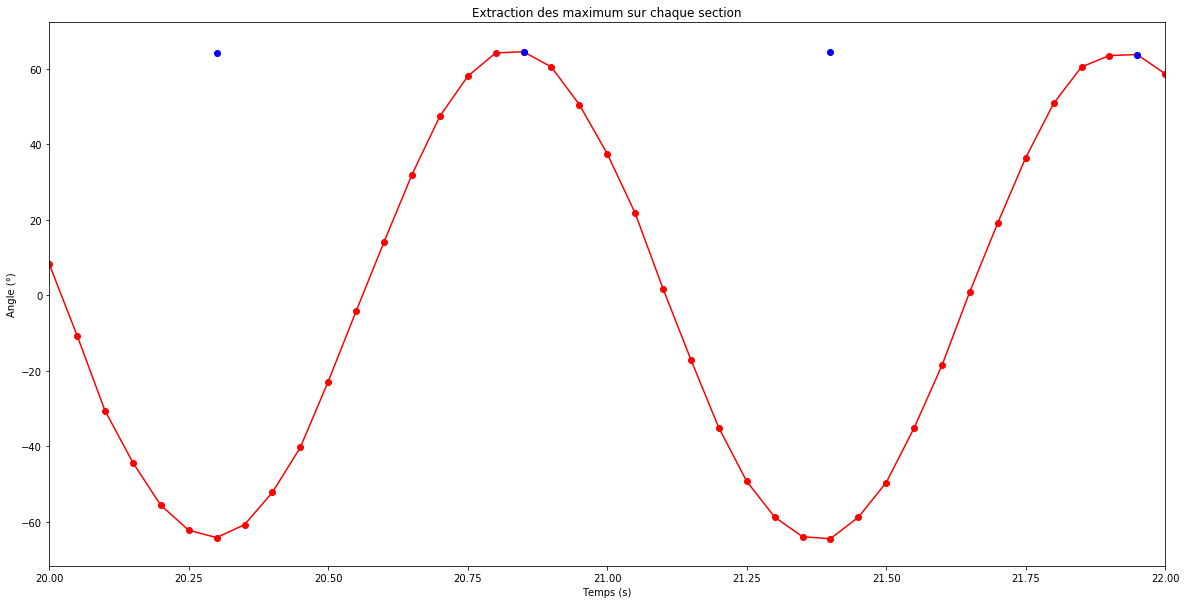

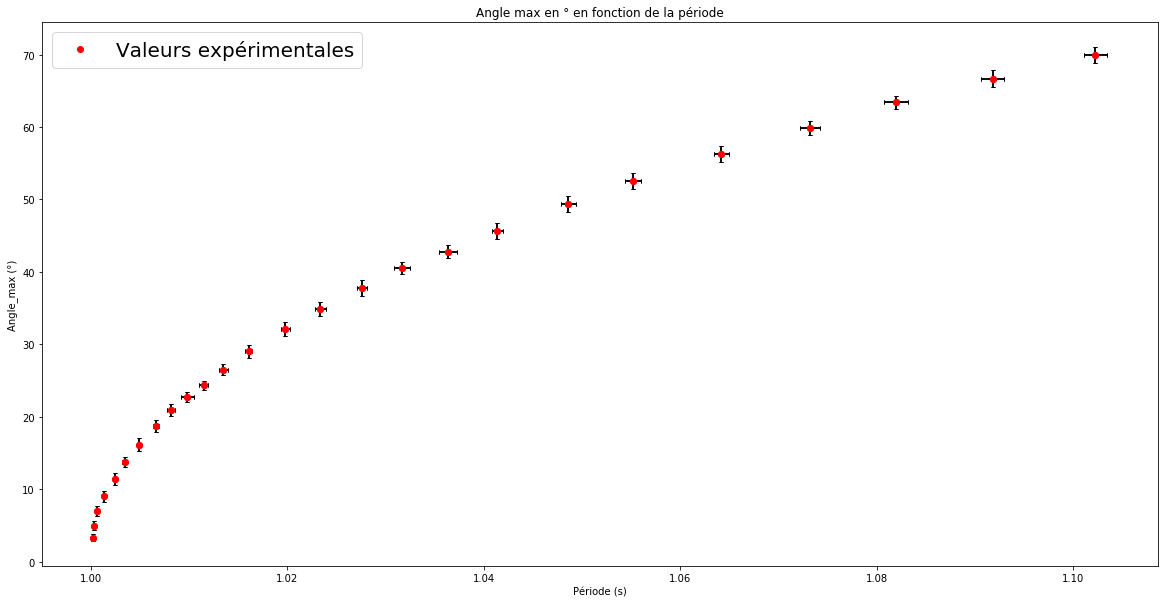

In [137]:
r"""Correction non-linéaires au pendule simple

Description
-----------
Ce programme permet un ajustement de données expérimentales au modèle du pendule non-linéaire.
À partir d'un unique fichier sur une oscillation amortie, le programme récupère pour les 
différents angles maximaux du mouvement, et les traite comme différents angles initiaux.
Puis le programme permet de tracer la période associée à chaque oscillation en fonction 
de l'angle initial

Informations
------------
Auteurs : Thomas Dupuis et la prépa agreg de Montrouge
Année de création : 2023
Version : 1
Version de Python : 3.11
Licence : Creative Commons Attribution - Pas d'utilisation Commerciale 4.0 International

Liste des modifications :
    * v 1.00 : 2023-07-16 Première version complète
"""

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import numpy as np
from scipy.optimize import curve_fit
from math import *

#Fonction utile pour l'ajustement

def bordaFunc(x,periode0,b):
    y = 180/pi*b*np.sqrt(x/periode0-1)
    return y

# Il faut enregistrer le fichier latis pro avec comme séparateur décimal un point et comme séparateur entre valeurs une virgule
# dans le répertoire courant du Jupyter.
# Attention de bien enregistrer une fois le pendule lancé. Choisir un temps d'échantillonage de 50 ms et une durée de + de 600 secondes
# sur LatisPro avec un pendule qui bat la seconde.

nomreadfile = "mecanique_myTable.txt" #fichier à lire
nomwritefile = "mecanique_resultsBorda.txt" #fichier à écrire
boolfit = False #booléen pour ajuster ou non

# On commence par lire le document pour extraire les informations d'angle et de temps

f = open(nomreadfile, "r")
lines = f.readlines()
isfirstline = 0;

temps = []
angle = []


for line in lines:
    if isfirstline==0:
        isfirstline=1
    else : 
        temps.append(float(line.split(',')[0]))
        angle.append(float(line.split(',')[1]))
 
longueurtemps = len(temps)
tempsechant = temps[1]-temps[0]


##################################### Détermination des annulations #########################################

#On recherche maintenant les temps pour lesquels le pendule passe par 0

tempspass0 = []
indicepass0 = []

#On commence par une recherche bête, puis on retirera les erreurs (les valeurs trop proches)
tempsinter1 =-1
tempsinter2 = -1
for i in range(len(temps)-1):
    #On cherche les changements de signe
    if angle[i]*angle[i+1]<=0:
        #On fait une interpolation avec les 2 points qui changent de signe
        tempsinter2 = (angle[i+1]*temps[i]-angle[i]*temps[i+1])/(angle[i+1]-angle[i])
        #On retire les points trop proches (erreurs liées à l'incertitude sur U de la plaquette SYSAM)
        if tempsinter1==-1 or tempsinter2-tempsinter1>3*tempsechant:
            tempspass0.append(tempsinter2)
            indicepass0.append(i)
            tempsinter1 = tempsinter2

#Affichage graphique des points trouvés
tdeb1 = 50
tfin1 = 70

f = plt.figure(1)
plt.plot(temps,angle, 'ro-')
plt.plot(tempspass0,[0]*len(tempspass0), 'bo')
plt.axis([tdeb1, tfin1, min(angle),max(angle)])
plt.title("Extraction des temps de passage par zéros")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (°)")

##################################### Détermination des maximums #########################################

#On va ensuite cherche les maximums entre chaque annulation
nbremax = len(indicepass0)-1
valeurmax = []
tempsmax = []

for i in range(nbremax):
    listetemp = []
    for x in angle[indicepass0[i]+1:indicepass0[i+1]]:
        listetemp.append(abs(x))
    tempsmax.append(temps[listetemp.index(max(listetemp))+indicepass0[i]+1])
    valeurmax.append(max(listetemp))

#Affichage graphique des points trouvés
tdeb2 = 20
tfin2 = 22
    
f = plt.figure(2)
plt.plot(temps,angle, 'ro-')
plt.plot(tempsmax,valeurmax, 'bo')
plt.axis([tdeb2, tfin2, min(angle),max(angle)])
plt.title("Extraction des maximum sur chaque section")
plt.xlabel("Temps (s)")
plt.ylabel("Angle (°)")

################################## Clustering ###################################

#On va maintenant faire du clustering (en supposant que l'amplitude ne fait que décroître)

varangle = 3 #pas pour le clustering
anglefinal = []
uanglefinal = []
periodefinal = []
uperiodefinal = []

inddeb = 0
i=1
while i<nbremax:
    valeurtemp =  valeurmax[inddeb]
    while i<nbremax and valeurmax[i]+varangle>valeurtemp:
        i+=1
    indfin = i
    anglefinal.append(np.mean(valeurmax[inddeb:indfin+1]))
    uanglefinal.append(np.std(valeurmax[inddeb:indfin+1]))
    periodefinal.append(2*(tempspass0[indfin]-tempspass0[inddeb])/(indfin-inddeb))
    uperiodefinal.append(2*(tempsechant/5)/(indfin-inddeb))
    inddeb = i+1
    i+=1

f = plt.figure(3)
plt.plot(periodefinal,anglefinal, 'ro')
plt.xlabel("Période (s)")
plt.ylabel("Angle_max (°)")
plt.errorbar(periodefinal, anglefinal, xerr = uperiodefinal, yerr = uanglefinal,fmt = 'none', capsize = 2, ecolor = 'black', zorder = 1)

if boolfit :
    par_fit,cov=curve_fit(bordaFunc,periodefinal,anglefinal,sigma=uanglefinal,absolute_sigma=True)
    T0est = par_fit[0]
    best = par_fit[1]
    chisquarered = sum((anglefinal-bordaFunc(periodefinal,T0est,best))**2/np.array(uanglefinal)**2)/len(periodefinal)
    print("Le Xcarréréduit vaut {}".format(chisquarered))

#Affichage et sauvegarde dans un fichier annexe

f = plt.figure(3)
plt.plot(periodefinal,anglefinal, 'ro',label ='Valeurs expérimentales')
plt.xlabel("Période (s)")
plt.ylabel("Angle_max (°)")
plt.errorbar(periodefinal, anglefinal, xerr = uperiodefinal, yerr = uanglefinal,fmt = 'none', capsize = 2, ecolor = 'black', zorder = 1)
xmod = np.linspace(T0est,max(periodefinal),100)
plt.title("Angle max en ° en fonction de la période")
if boolfit :
    plt.plot(xmod,bordaFunc(xmod,T0est,best),'k--',label="Modèle")
    plt.text(T0est, max(anglefinal)/2, r'$\chi^2_{réd}$='+"{:.2f} ".format(chisquarered),fontsize="20")
plt.legend(fontsize="20")


f = open(nomwritefile, "a")
for i in range(len(periodefinal)):
    f.write("{} {} {} {}\n".format(periodefinal[i],uperiodefinal[i],anglefinal[i],uanglefinal[i]))

In [129]:
best

3.8982761935174812